## 一. 環境設置
引進使用的資料集

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
import os
import itertools
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from plot_cm import plot_confusion_matrix

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def feat_extraction(path):
    '''
    Input: path for a single file
    Output: 1D feature vector
    (1) Read file using librosa
    (2) Use librosa to calculate MFCC
    (3) Aggregate the 2D MFCC along time axis to 1D feature vector (ex: mean, std ...)
    '''
    audio, _ = librosa.load(path)
    mfcc = librosa.feature.mfcc(audio)
    feat = np.average(mfcc, axis=1)
    return feat

讀取dataset

In [5]:
RANDSEED = 0 # setup random seed
CVFOLD = 5 # number of folds of cross validation
classNames = ['Dog bark', 'Rain', 'Sea waves', 'Baby cry',
              'Clock tick', 'Person sneeze', 'Helicopter', 'Chainsaw',
              'Rooster', 'Fire crackling']

##### Load data & Calculate features MFCC
labels = pd.read_csv('../data/label.csv')
nameToLabel = dict((row['filename'], row['label']) for idx, row in labels.iterrows())
trainFiles = sorted(glob('../data/Train/*/*.ogg'))
testFiles = sorted(glob('../data/Test/*/*.ogg'))
trainLabel = np.array([nameToLabel[os.path.basename(p)] for p in trainFiles])
testLabel = np.array([nameToLabel[os.path.basename(p)] for p in testFiles])

## 二. baseline訓練
抽取特徵

In [6]:
trainFeat = np.vstack([feat_extraction(p) for p in trainFiles])
testFeat = np.vstack([feat_extraction(p) for p in testFiles])

分割trainging set與testing set並進行標準化

In [7]:
##### Perform cross-validation
'''
(1) Use KFold to perform cross validation
(2) Normalize training set and testing set
(3) Collect result from each fold
(4) Calculate accuracy and confusion matrix
'''
X_train = trainFeat # 分訓練集和測試集
y_train = trainLabel
X_test = np.vstack(testFeat)
y_test = np.array(testLabel)

sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

呼叫k-fold以及SVM，並設置計數變數以方便計算正確率

In [8]:
Kf = KFold(n_splits=CVFOLD, shuffle=True, random_state=RANDSEED) # k-fold設置
svm = SVC(kernel='linear', C=1.0, random_state=1) #Call SVM algorithm

y_pred = [] # 每個fold的預測結果
y_pred_total = [] # 所有fold的正確結果
y_ans = [] # testing set的重新排列
scores = []

開始訓練，5fold中4個做training，1個做validation。並繪製training set的confusion matrix。

Confusion matrix


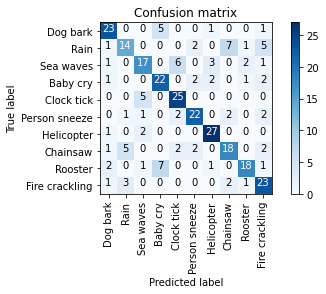

ACC =  0.6966666666666667


In [9]:
for cvIdx, (trainIdx, devIdx) in enumerate(Kf.split(range(len(X_train)))):
    svm.fit(X_train_std[trainIdx], y_train[trainIdx])
    y_pred = svm.predict(X_train_std[devIdx]) # 每次fold的預測結果
    y_pred_total.extend(y_pred)
    y_ans.extend(y_train[devIdx])

cm = confusion_matrix(y_true=y_ans, y_pred=y_pred_total)
plot_confusion_matrix(cm , classNames)
accuracy = accuracy_score(y_ans, y_pred_total)
print('ACC = ',  accuracy)

對testing set做預測並繪製混淆矩陣。

Confusion matrix


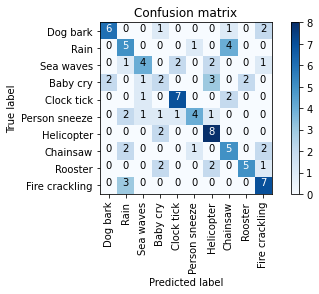

ACC =  0.53


In [10]:
##### Predict on test set
'''
(1) Train a model based on your best parameters
(2) Prediction on test set
(3) Calculate accuracy and confusion matrix
'''
y_test_pred = svm.predict(X_test_std)

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
plot_confusion_matrix(cm, classNames)
print('ACC = ',  accuracy)

## 三. 不同feature的探討

我們模型的問題有三：
(1) 有嚴重的overfitting問題 
(2) 沒有最佳化 
(3) 平均值不一定是最適合此問題的feature

Model 1

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

0.7166666666666666
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [12]:
clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
print('Test accuracy: %.3f' % clf.score(X_test_std, y_test)) # 對測試集進行預測

Test accuracy: 0.620


Confusion matrix


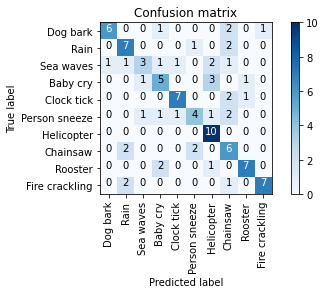

In [14]:
y_pred_total = clf.predict(X_test_std)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_total)
plot_confusion_matrix(cm, classNames)

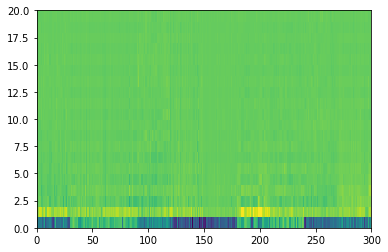

In [15]:
plt.show()
fig, (ax_1) = plt.subplots(1,1)
ax_1.pcolor(trainFeat.T)
plt.savefig("heatmap.png",dpi=500)
plt.show()

Model 2

In [16]:
def feat_extraction_avg_13(path):
    audio, _ = librosa.load(path)
    mfcc = librosa.feature.mfcc(audio)[:13]
    feat = np.average(mfcc, axis=1)
    return feat

In [17]:
trainFeat = np.vstack([feat_extraction_avg_13(p) for p in trainFiles])
testFeat = np.vstack([feat_extraction_avg_13(p) for p in testFiles])

X_train = trainFeat # 分訓練集和測試集
y_train = trainLabel
X_test = np.vstack(testFeat)
y_test = np.array(testLabel)

sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [18]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

0.7
{'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [19]:
clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
print('Test accuracy: %.3f' % clf.score(X_test_std, y_test)) # 對測試集進行預測

Test accuracy: 0.740


Confusion matrix


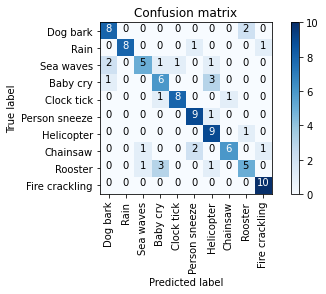

In [20]:
y_pred_total = clf.predict(X_test_std)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_total)
plot_confusion_matrix(cm, classNames)

Model 3

In [21]:
def feat_extraction_mean_13(path):
    audio, _ = librosa.load(path)
    mfcc = librosa.feature.mfcc(audio)[:13]
    feat = np.mean(mfcc, axis=1)
    return feat

In [22]:
trainFeat = np.vstack([feat_extraction_mean_13(p) for p in trainFiles])
testFeat = np.vstack([feat_extraction_mean_13(p) for p in testFiles])

X_train = trainFeat # 分訓練集和測試集
y_train = trainLabel
X_test = np.vstack(testFeat)
y_test = np.array(testLabel)

sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [23]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

0.7
{'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


In [24]:
clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
print('Test accuracy: %.3f' % clf.score(X_test_std, y_test)) # 對測試集進行預測

Test accuracy: 0.740


Confusion matrix


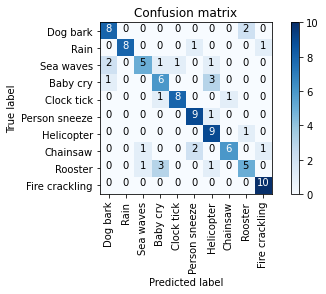

In [25]:
y_pred_total = clf.predict(X_test_std)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_total)
plot_confusion_matrix(cm, classNames)

Model 4

In [30]:
def feat_extraction_avg_std26(path):
    audio, _ = librosa.load(path)
    mfcc = librosa.feature.mfcc(audio)[:13]
    feat1 = np.average(mfcc, axis=1)
    feat2 = np.std(mfcc, axis=1)
    feat = np.concatenate((feat1, feat2))
    return feat

In [31]:
trainFeat = np.vstack([feat_extraction_avg_std26(p) for p in trainFiles])
testFeat = np.vstack([feat_extraction_avg_std26(p) for p in testFiles])

X_train = trainFeat # 分訓練集和測試集
y_train = trainLabel
X_test = np.vstack(testFeat)
y_test = np.array(testLabel)

sc = StandardScaler() # 標準化
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [32]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# 超參數挑選範圍
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

# 使用網格搜尋法
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train_std, y_train)

# 輸出結果
print(gs.best_score_) # 最佳的正確率
print(gs.best_params_) # 最佳參數組合

0.75
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [33]:
clf = gs.best_estimator_ # 取得剛剛算出的最佳參數
clf.fit(X_train_std, y_train) # 用這個參數train出model
print('Test accuracy: %.3f' % clf.score(X_test_std, y_test)) # 對測試集進行預測

Test accuracy: 0.730


Confusion matrix


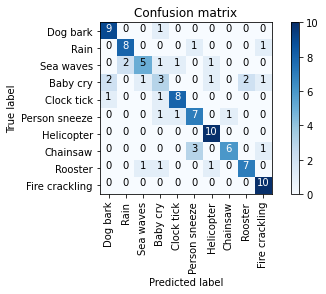

In [34]:
y_pred_total = clf.predict(X_test_std)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_total)
plot_confusion_matrix(cm, classNames)